# Smokescreen Prototype

This is an exploratory prototying notebook for the Smokescreen project.
Loading firecrown likelighoods, smokescreen will try to find to conceal the data-vectors to avoid confirmation bias in the cosmological parameters.

In [1]:
%matplotlib inline
import pylab as plt
from firecrown.likelihood.likelihood import load_likelihood
from firecrown.likelihood.likelihood import load_likelihood_from_module_type
from firecrown.parameters import ParamsMap
import numpy as np
import sacc
import pathlib
import pyccl as ccl
from firecrown.modeling_tools import ModelingTools
import firecrown
import sys
import os
# we need to import a firecrown example likelihood:
# exports the path to the environment variable FIRECROWN_DIR
os.environ["FIRECROWN_DIR"] = os.path.dirname('/Users/loureiro/Work/Github/firecrown/')


In [2]:
# importing the example likelihood module from the firecrown examples
sys.path.append(os.path.join(os.environ["FIRECROWN_DIR"], "examples", "des_y1_3x2pt"))
# trying to import the example likelihood
import des_y1_3x2pt_PT 

In [3]:
print(hasattr(des_y1_3x2pt_PT, "build_likelihood"))

True


## Generating a theory-vector

In [4]:
# ccl cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      sigma8=0.8, 
                      n_s=0.96, 
                      transfer_function='bbks')
cosmo.compute_nonlin_power()

In [6]:
# preparting the likelihood
likelihood, tools = load_likelihood_from_module_type(des_y1_3x2pt_PT, {})

Using parameters: ['src0_delta_z', 'lens0_mag_bias', 'ia_a_2', 'lens0_b_s', 'lens0_delta_z', 'ia_a_d', 'lens0_b_2', 'ia_a_1', 'lens0_bias']


This comes from the example file, but we would expect the user to provide a dictionary of fiductial parameters for the systeamatics

In [8]:
cs = des_y1_3x2pt_PT.CclSetup()
systematics_params = ParamsMap(
        {
            "ia_a_1": cs.a_1,
            "ia_a_2": cs.a_2,
            "ia_a_d": cs.a_d,
            "lens0_bias": cs.b_1,
            "lens0_b_2": cs.b_2,
            "lens0_b_s": cs.b_s,
            "lens0_mag_bias": cs.mag_bias,
            "src0_delta_z": 0.000,
            "lens0_delta_z": 0.000,
        }
    )

In [10]:
tools.update({})
tools.prepare(cosmo)
likelihood.update(ParamsMap(systematics_params))

In [11]:
theory_vec_fid = likelihood.compute_theory_vector(tools)
data_vect_original = likelihood.get_data_vector()

/opt/homebrew/Caskroom/miniforge/base/envs/desc_blinding/lib/python3.11/site-packages/pyccl/nl_pt/ept.py:375: CCLWarning: EulerianPTCalculators assume linear galaxy bias when computing galaxy-IA cross-correlations.
  warnings.warn(


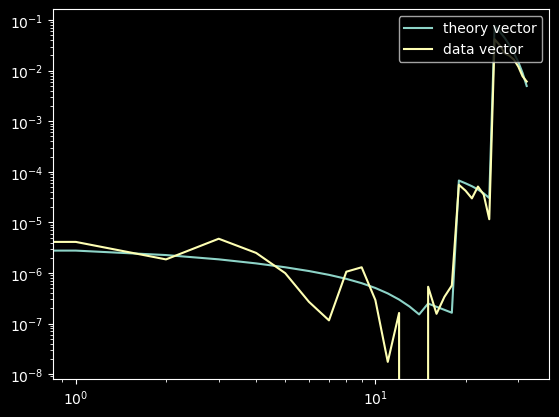

In [16]:
plt.figure()
plt.loglog(theory_vec_fid, label='theory vector')
plt.loglog(data_vect_original, label='data vector')
plt.legend(loc=1)
plt.show()